Dou et al. (2020) model

Agora em Julia versão 1.5.3

This script has only the solution. For a more complete script, with unit testing and graphs, refer to "BargainingJulia"

In [1]:
using LinearAlgebra, Statistics

# using Distributions, Expectations, NLsolve, Roots, Random, Plots, Parameters

using VegaLite
using DataFrames


#packages to increase the speed of the code
using BenchmarkTools
using Profile # @profile command
using ProfileVega #profiling using graphs
# using StatProfilerHTML
using ProfileView #profiling using graphs
# using Traceur #analyses if your function has performance flaws such as changing the type of a variable


┌ Info: Precompiling VegaLite [112f6efa-9a02-5b7d-90c0-432ed331239a]
└ @ Base loading.jl:1278
┌ Warning: `@get!(dict, key, default)` at C:\Users\Zé\.julia\packages\Requires\9Jse8\src\require.jl:11 is deprecated, use `get!(()->default, dict, key)` instead.
└ @ Base deprecated.jl:204
┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1278
┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1278
┌ Info: Precompiling ProfileVega [4391764f-db79-4bd7-a4c6-f9062de4300e]
└ @ Base loading.jl:1278
┌ Info: Precompiling ProfileView [c46f51b8-102a-5cf2-8d2c-8597cb0e0da7]
└ @ Base loading.jl:1278


Game parameters

In [2]:
const μ = Float64(4.566); #number of months in each period
const ρ = Float64(0.884); # (1 - ρ) is the firm's depreciation rate each period
# const ρ = Float64(0.5);#testing new depreciation rate
const β = Float64(9.84); #inverse of the speed of learning
const c0 = Float64(0.044); #fixed cost of going to court
const c1 = Float64(0.015); #variable cost of going to court


const hs0 = Float64(0.28); #senior's initial skill level
const hj0 = Float64(0.36); #junior's initial skill level

const λj = Float64(0.346);

#const is to alert Julia that these global variables will not change, so she does not have to worry about then

Data

In [3]:
const Vmax = Float64(1.0); #firm's maximum reorganization value
const L = Float64(0.25); #firm's maximum liquidation value
const Ds = Float64(0.32); #senior's debt face value
const Dj = Float64(0.68); #junior's debt face value

const D = Ds + Dj; #total debt, used to scale costs

Initial definitions: costs, maximum value of the firm, maximum number of periods



In [4]:
#number of periods
function max_turns(Vmax, L, ρ)
    t = 0
    
    #using the specification of the theoretical model
    #we are not considering the change in indexation from t to t+1 yet.
    while(ρ^(t-1) * Vmax > L)
        t = t+1
    end
    return t
end


T = max_turns(Vmax, L, ρ);


### Important: we will create a game with T+1 periods

So we'll be able to include period t==0 in the arrays as index 1

So the notation is: period t is represented by the index t-1


In [5]:
#cost function
function Ct(t)
    #cost at period t=0(index1) is 0
    if(t <= 1)
        return 0
    else
        return c0 * D + c1 * (t-1) * D #test to make index==1 be t==0
    end
end



Ct (generic function with 1 method)

In [6]:
#maximum value of reorganization each period
function Vt(Vmax, ρ, t)
    
    if(t <=1)
        return Vmax
    else
        #(t-2) instead of (t-1) because we shifted the indexes in the game so as to include t==0 at index==1
        return ρ^(t-2) * Vmax
    end
    
    
end

#index 1 corresponds to t=0 and 2 to t=1...

Vt (generic function with 1 method)

In [7]:
#liquidation payoffs

function s_L(t)
    return min(L - Ct(t), Ds)
end



function j_L(t)
    return min(L - Ct(t) - s_L(t), Dj)
end


j_L (generic function with 1 method)

Skill levels' grid and Probability Mass Function(PMF)

Important: we won't use the skill levels directly in the functions, we will use their indexes. For example, index = 40 corresponds to $\theta_{K,t} = 0.4$.

In [8]:
#grid size
const grid = 100;

hlow = 0.01;
hhigh = 1.0;


hvals = LinRange(hlow, hhigh, grid);


In [9]:
#array to tell the size of the pie at period t, according to reorganization skill levels
#arguments: (period, θkt)
U = Array{Float64}(undef, T+1, grid);


for t in 1:T+1
    for h in 1:grid
        U[t,h] = hvals[h] * Vt(Vmax, ρ, t) - Ct(t)
    end
end

In [10]:
#cumulative distribution function
function cdf(x, lt)
    
    #return the cdf of x given the lower bound lt
    #geq than 1 because of our discretization method 
    if(x >= 1.0)
        
        return 1.0
    
    else
        
        if(x >= lt)
            return 1.0 - ((1.0-x)^β)/((1-lt)^β)
        else
            return 0.0
        end
    end
end


cdf (generic function with 1 method)

In [11]:
#pmf: each point of the grid is at the center of the cdf
function pmf_cdf(lt, δ = hlow/2)
    pmf = zeros(grid)
    
    for (i, h) in enumerate(hvals)
        pmf[i] = cdf(h+δ, lt) - cdf(h-δ, lt)
    end
    
    return pmf
end


pmf_cdf (generic function with 2 methods)

In [12]:
#generating the pmfs

#probability mass function
pmf = Array{Float64}(undef,grid,grid)


for (t, θt) in enumerate(hvals)
    pmf[t,:] = pmf_cdf(θt)
end


#we need a pmf for when we have lkt and want to know θk,t+1
#we will call it 'pmf2'
pmf2 = similar(pmf)

for i in eachindex(hvals)
    for j in eachindex(hvals)
        pmf2[i, j] = sum(pmf[i, :] .* pmf[:, j])
    end
end

Arrays with the continuation values

In [13]:
#continuation values
#period t (not t+1), θkt, ℓkt, ℓmt
s_W = zeros(T+1, grid, grid, grid);
j_W = similar(s_W);


#optimal payments
#period, θkt, ℓmt, outputs
Pst_array = zeros(T, grid, grid, 6); #we won't need payment proposal for period T, a.k.a. "T+1"
Pjt_array = similar(Pst_array);

In [14]:
#populating the last period with the liquidation values
s_W[T+1, :, :, :] .= s_L(T+1); #we need to use .= because it is a broadcast
j_W[T+1, :, :, :] .= j_L(T+1);

In [15]:
#cutoff function: upgrade

function getcutoff_m(t, pkt, hkt, m_W)

    #we extract the diagonal values, where θmt == lmt, to search for the cutoff
    diag_vals = @views diag(m_W[t+1, :, :, hkt])
    
    
    #we don't need to worry about negative payment offers because in this case the cutoff will be 1
    #if the pkt is greater than all the continuation values of the adversary, then it will return '101' (grid+1)
    return searchsortedfirst(diag_vals, pkt)
end

getcutoff_m (generic function with 1 method)

In [16]:
#function to "filter" the cutoff

function cutoff_m(t, pkt, hkt, lmt, m_W)
    #for now, it will just tell us if the payment offer is negative
    
    #if payment is negative (waiting offer), the cutoff will be 102 (grid+2), a code for the adversary to always reject it
    if(pkt<0)
         return grid+2
    end
    
    cmt = getcutoff_m(t, pkt, hkt, m_W)
    
    return cmt

    
#     #if there is no cutoff (cutoff==101), then cutoff_m will return 101
#     if(cmt==101)
#         return cmt
#     else
#         return max(cmt, lmt)
#     end
end

cutoff_m (generic function with 1 method)

In [17]:
#function to select the pmf function as it is writen in the paper

function h_m(t, lmt, pmf, pmf2)
    #takes the indexes of cutoff and lmt
        
    #at t=0(index 1), all information is symmetric, so we use pmf instead of pmf2
    if(t <= 1)
        return pmf[lmt, 1:end]
    else
        return pmf2[lmt, 1:end]
    end
end
    

h_m (generic function with 1 method)

In [18]:
#version passing global variables as parameters


grid_payment = 1000;
share = LinRange(hlow, hhigh-hlow, grid_payment);

#testing cutoff in this newer version of Pkt

#function to calculate the optimal payment offer and directly populate the array

function Pkt(t, hkt, lmt, k_W, m_W, k_L, Pkt_array, pmf, pmf2, share, U)
    
    
    
    Pkt_grid = Vector{Float64}(undef, length(share)+1)

#     Pkt_grid = zeros(length(share)+1)
    
    #the first input is -Vmax, to assure that m will reject all offers. It is the waiting payoff
    Pkt_grid[1] = -Vmax

    #t+1 is just because we have T+1 periods in U, so U[1] is t==0 and U[T] is t==T-1
    #the reorganization payoff is U_{t} (\theta_{t+1})
    Pkt_grid[2:end] .= U[t, hkt] .* share
    
    #discarding values below the lowest continuation value of the opponent
    #this way we won't mistake a waiting offer for a reorganization offer

    #descartando os valores que são menores que o menor valor de continuação possível do adversário
    #assim não confundiremos uma proposta de reorganização com uma de espera
#     lowest = m_W[t+1, lmt, lmt, hkt]

#     Pkt_grid[2:end] = @. ifelse(Pkt_grid[2:end] < lowest, lowest, Pkt_grid[2:end])
    
    #screening cutoffs
    cmt = Vector{Int64}(undef, length(Pkt_grid))

     #loop for calculating the cmt
    for (i, Pkt) in enumerate(Pkt_grid)
        cmt[i] = cutoff_m(t, Pkt, hkt, lmt, m_W)
    end

    
    payoff = zeros(length(Pkt_grid))
    
    
    #pmf of m is a function of t (at t=0 (index 1), the information is symmetric)
    probm = h_m(t,lmt, pmf, pmf2)
    
    for (i, pkt) in enumerate(Pkt_grid)
        if(cmt[i]==grid+2) 
            #means that pkt<0, so it will be always rejected
            #lmt+1 == lmt
            payoff[i] += dot(@view(k_W[t+1, hkt:end, hkt, lmt]), @view(pmf[hkt, hkt:end])) 
        
        
        
        elseif(cmt[i] == grid+1) 
            #means that cutoff doesn't exist, so the payment offer will be accepted by all θmt+1

            #since sum(probm[lmt:end])==1, we didn't include it here
            payoff[i] += dot(@view(U[t, hkt:end]) .- pkt, @view(pmf[hkt, hkt:end]))
        
        else
            #cases where cmt[i] is between 1 and grid
            
            if(cmt[i] < lmt)
                #means that pkt<minimum continuation value of m, so it will be always rejected
                #similar to pkt<0
                #lmt+1 == lmt
                payoff[i] += dot(@view(k_W[t+1, hkt:end, hkt, lmt]), @view(pmf[hkt, hkt:end]))
                
            elseif(cmt[i]==lmt)
                
                #accepted only if hmt+1==lmt
                payoff[i] += dot(@view(U[t, hkt:end]) .- pkt, @view(pmf[hkt, hkt:end])) * probm[lmt]
                
                #rejected otherwise
                payoff[i] += dot(@view(k_W[t+1, hkt:end, hkt, lmt]), @view(pmf[hkt, hkt:end])) * sum(@view(probm[(lmt+1):end]))
                
            else
                #cmt[i] > lmt
                #accepted if hmt+1 <=cmt[i]
                payoff[i] += dot(@view(U[t, hkt:end]) .- pkt, @view(pmf[hkt, hkt:end])) * sum(@view(probm[lmt:cmt[i]]))
                
                
                #rejected otherwise
                #lmt+1 = cmt[i]
                payoff[i] += dot(@view(k_W[t+1, hkt:end, hkt, cmt[i]]), @view(pmf[hkt, hkt:end])) * sum(@view(probm[(cmt[i]+1):end]))
            
            end
        end
    end
    
    
    
    #payoffs matrix####

#     payoff_reorg, index_reorg = findmax(payoff[2:end])
    payoff_reorg, index_reorg = findmax(payoff)
    payment = Pkt_grid[index_reorg]

    

    #calculating the optimal policy between liquidating, reorganizing or waiting ####
    payoff_liq = k_L(t)

    #waiting payoff is associated with the first possible payment, the waiting offer(-Vmax)
    payoff_wait = payoff[1]

    payoff_max, policy = findmax((payoff_liq, payoff_wait, payoff_reorg))
    
    
    #condition to always show the payoff reorg
#     if(policy==3.0)
#         payment = Pkt_grid[index_reorg+1]
#     else
#         payment = -Vmax
#     end

    #populates the array
    Pkt_array[t, hkt, lmt, :] .= payment, cmt[index_reorg], payoff_reorg, payoff_wait, payoff_max, policy
    
end



Pkt (generic function with 1 method)

In [19]:
# Pkt(t, hkt, lmt, k_W, m_W, k_L, Pkt_array, pmf, pmf2, share, U)

function Pst(t, θst, ℓjt)
    return Pkt(t, θst, ℓjt, s_W, j_W, s_L, Pst_array, pmf, pmf2, share, U)
end


function Pjt(t, θjt, ℓst)
    return Pkt(t, θjt, ℓst, j_W, s_W, j_L, Pjt_array, pmf, pmf2, share, U)
end

Pjt (generic function with 1 method)

In [20]:
#populating the arrays to continue the tests
#we populate period T-1, whose index is T
t = T
for h in 1:grid
    for l in 1:grid
            Pst(t, h, l)
            Pjt(t, h, l)
    end
end

In [21]:
#optimal proposal
function propose(t, hkt, lkt, lmt, Pkt_array)
    
    
    #it just searches for the corresponding Pkt
    payoff_max, policy = @views Pkt_array[t, hkt, lmt, end-1:end]
    
    return payoff_max, policy
end

propose (generic function with 1 method)

In [22]:
#"cdf" for the discretized distribution
function cdf_discrete(x, lt, pmf)

    #returns the probability that θt takes a value less than or equal to x, given lt
    #if needed, ie in threshold, we can just subtract 0.01 from x, so cdf_discrete the prob that θt < x, strictly
    return sum(@view(pmf[lt, lt:x]))
end

cdf_discrete (generic function with 1 method)

In [23]:
#function to calculate the payment offer threshold ϕmt

function threshold_m(t, lkt, lmt, Pmt_array)
    
    #searches the index where the optimal policy is either 2.0 or 3.0 (wait or reorganize)
    #"Return the index of the first value in a greater than or equal to x, according to the specified order. 
    #Return length(a) + 1 if x is greater than all values in a. a is assumed to be sorted."
    ts = @views searchsortedfirst(Pmt_array[t, :, lkt, end], 2.0)
    
    
    #returns error message if threshold does not exist (101 is returned if missing by searchsortedfirst)
    @assert ts < 101
    
    return ts
    
end

threshold_m (generic function with 1 method)

In [24]:
function prob_liq_m(t, ts, lmt, pmf)
    
    #probability that m will propose liquidation next period
    
    #at t==0 (index 1), the info is symmetric, so lmt == θmt, thus it becomes the indicator function
    if(t<=1)
        if(lmt >= ts)
            return 0.0
        else
            return 1.0
        end


    else#if t>0(index>1)

        if(lmt >= ts)
            return 0.0
        else
            return cdf_discrete(ts-1,lmt, pmf) #we subtract 1 because we want prob(θt < ts)
        end

    end
    
    
end

prob_liq_m (generic function with 1 method)

In [25]:
#expected payoff of answering a payment proposal

function respond_payment(t, hkt, lkt, lmt, Pmt_array, k_W, pmf)
    
    
    #the minimum level of hmt necessary for m to offer a payment
    #it will be used as hmt
    ts = threshold_m(t, lkt, lmt, Pmt_array)
    
    #updated lower bound
    lmt = max(ts, lmt)


    #the possible values of payment given by the opponent
    Pmt_grid = Pmt_array[t, lmt:end, lkt, 1]
    
    
    #the screening cutoffs associated with each payment proposal
    #indexet by k because now it is k who is being screened
    ckt = Vector{Int64}(undef, length(Pmt_grid))
    ckt .= Pmt_array[t, lmt:end, lkt, 2]

    payoff = zero(0.0)
#     payoff = Array{Float64}(undef, length(Pmt_grid))



    for (i, pmt) in enumerate(Pmt_grid)
        
        if(ckt[i]==grid+2)
            #means that the payment offer is negative (waiting offer)
            #the proposal will be rejected for sure, without lowerbound update
            payoff += dot(@view(k_W[t+1, hkt:end, lkt, lmt+(i-1)]), @view(pmf[hkt, hkt:end])) * pmf[lmt, lmt+(i-1)]
            
        
        
        elseif(ckt[i]==grid+1)
            #means that there is no cutoff, K will accept the payment offer for all θkt+1
#             payoff += pmt * sum(@view(pmf[hkt, hkt:end])) * pmf[lmt, lmt+(i-1)]
            payoff += pmt * pmf[lmt, lmt+(i-1)]
            
        else
            
            if(ckt[i] < lkt)
                #the proposal will be rejected for sure, without lowerbound update
                payoff += dot(@view(k_W[t+1, hkt:end, lkt, lmt+(i-1)]), @view(pmf[hkt, hkt:end])) * pmf[lmt, lmt+(i-1)]
            
            elseif(ckt[i]==lkt)
                #will accept only if hkt+1==lkt
                payoff += pmt * pmf[hkt, lkt] * pmf[lmt,lmt+(i-1)]
                
                #rejects otherwise
                payoff += dot(@view(k_W[t+1, lkt+1:end, lkt, lmt+(i-1)]), @view(pmf[hkt, lkt+1:end])) * pmf[lmt, lmt+(i-1)]
                
            else
            #now ckt > lkt
                
                if(ckt[i] < hkt)
                    #he rejects, but there is an update in the lowerbound lkt+1==ckt
                    payoff += dot(@view(k_W[t+1, hkt:end, ckt[i], lmt+(i-1)]), @view(pmf[hkt, hkt:end])) * pmf[lmt, lmt+(i-1)]
                
                    
                else
                    
                    #receives pmt if his skill level is below or equal to the cutoff
                    payoff += pmt * sum(@view(pmf[hkt, hkt:ckt[i]])) * pmf[lmt, lmt+(i-1)]
                    
                    
                    #receives continuation value k_W if his skill level greather than the cutoff
                    payoff += dot(@view(k_W[t+1, ckt[i]+1:end , ckt[i], lmt+(i-1)]), @view(pmf[hkt, ckt[i]+1:end])) * pmf[lmt, lmt+(i-1)]
                    
                    
                end
            end
        end
    end
    
    return payoff
end


respond_payment (generic function with 1 method)

In [26]:
#expected payoff of answering a liquidation proposal

function respond_liq(t, hkt, lkt, lmt, k_L, m_L, pmf, U)
    
    #payoff_reorg is the payoff of reorganizing while paying the opponent's liquidation value
    #U_{t} (\theta_{t+1}) because the skill level is of the next period
    #dot is matrix multiplication
    payoff_reorg = dot(@view(pmf[hkt, hkt:end]), (@view(U[t, hkt:end]) .- m_L(t)))
    
    payoff_liq = k_L(t)
    
    return max(payoff_liq, payoff_reorg)
end

respond_liq (generic function with 1 method)

In [27]:
#expected payoff of being called to respond
function respond(t, hkt, lkt, lmt, Pmt_array, k_W, k_L, m_L, pmf, U)
    
    probm_liq = prob_liq_m(t, threshold_m(t, lkt, lmt, Pmt_array), lmt, pmf)
    
    
    return (1.0 - probm_liq) * respond_payment(t, hkt, lkt, lmt, Pmt_array, k_W, pmf) + probm_liq * respond_liq(t, hkt, lkt, lmt, k_L, m_L, pmf, U)
end

respond (generic function with 1 method)

In [28]:
#defining S functions based on the generic functions

#Pkt(t, hkt, lmt, k_W, m_W, k_L)
function Pst(t, θst, ℓjt)
    return Pkt(t, θst, ℓjt, s_W, j_W, s_L, Pst_array, pmf, pmf2, share, U)
end

#propose(t, hkt, lkt, lmt, Pkt_array)
function s_propose(t, θst, ℓst, ℓjt)
    return propose(t, θst, ℓst, ℓjt, Pst_array)
end

#threshold_m(t, lkt, lmt, Pmt_array)
function threshold_j(t, ℓst, ℓjt)
    return threshold_m(t, ℓst, ℓjt, Pjt_array)
end


#respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W)
function s_respond_payment(t, θst, ℓst, ℓjt)
    return respond_payment(t, θst, ℓst, ℓjt, Pjt_array, s_W, pmf)
end


#respond_liq(t, hkt, lkt, lmt, k_L, m_L)
function s_respond_liq(t, θst, ℓst, ℓjt)
    return respond_liq(t, θst, ℓst, ℓjt, s_L, j_L, pmf, U)
end

    
#respond(t, hkt, lkt, lmt, Pmt_array, k_W, k_L, m_L) 
function s_respond(t, θst, ℓst, ℓjt)
    return respond(t, θst, ℓst, ℓjt, Pjt_array, s_W, s_L, j_L, pmf, U)
end

s_respond (generic function with 1 method)

In [29]:
#J's functions based on the generic functions
function Pjt(t, θjt, ℓst)
    return Pkt(t, θjt, ℓst, j_W, s_W, j_L, Pjt_array, pmf, pmf2, share, U)
end


function j_propose(t, θjt, ℓjt, ℓst)
    return propose(t, θjt, ℓjt, ℓst, Pjt_array)
end

function threshold_s(t, ℓjt, ℓst)
    return threshold_m(t, ℓjt, ℓst, Pst_array)
end

function j_respond_payment(t, θjt, ℓjt, ℓst)
    return respond_payment(t, θjt, ℓjt, ℓst, Pst_array, j_W, pmf)
end

function j_respond_liq(t, θjt, ℓjt, ℓst)
    return respond_liq(t, θjt, ℓjt, ℓst, j_L, s_L, pmf, U)
end    

function j_respond(t, θjt, ℓjt, ℓst)
    return respond(t, θjt, ℓjt, ℓst, Pst_array, j_W, j_L, s_L, pmf, U)
end

j_respond (generic function with 1 method)

### Populating the game's arrays

In [30]:
function populate_periods!(tfinal, tbegin)
    
    @time begin


        for t in tfinal:-1:tbegin

            @time begin
                #populating Pkt
                for l in 1:grid
                    for h in 1:grid
                        Pst(t, h, l)
                        Pjt(t, h, l)
                    end
                end

                #populating Wkt
                for lm in 1:grid
                    for lk in 1:grid
                        for hk in lk:grid #populates only when hk>=lk, to save time
                            s_W[t, hk, lk, lm] = λj * s_respond(t, hk, lk, lm) + (1-λj) * s_propose(t, hk, lk, lm)[1]
                            j_W[t, hk, lk, lm] = λj * j_propose(t, hk, lk, lm)[1] + (1-λj) * j_respond(t, hk, lk, lm)
                        end
                    end
                end
            end

        end
        
    end
        
end

populate_periods! (generic function with 1 method)

### Populating the whole game

In [31]:
populate_periods!(T,1)

  5.349993 seconds (20.56 M allocations: 4.015 GiB, 12.00% gc time)
 10.441558 seconds (24.13 M allocations: 7.507 GiB, 11.23% gc time)
 13.347251 seconds (28.34 M allocations: 10.295 GiB, 12.09% gc time)
 19.923840 seconds (31.60 M allocations: 12.648 GiB, 11.52% gc time)
 19.132239 seconds (34.18 M allocations: 14.566 GiB, 12.97% gc time)
 21.265123 seconds (36.10 M allocations: 16.060 GiB, 13.05% gc time)
 21.988374 seconds (37.89 M allocations: 17.491 GiB, 13.60% gc time)
 21.850168 seconds (39.12 M allocations: 18.498 GiB, 13.90% gc time)
 22.722850 seconds (40.05 M allocations: 19.273 GiB, 13.92% gc time)
 23.415747 seconds (40.93 M allocations: 20.013 GiB, 14.18% gc time)
 23.866002 seconds (41.58 M allocations: 20.560 GiB, 14.06% gc time)
 24.564405 seconds (42.22 M allocations: 21.096 GiB, 14.13% gc time)
 25.217903 seconds (43.14 M allocations: 21.953 GiB, 14.43% gc time)
254.646334 seconds (459.87 M allocations: 203.979 GiB, 13.33% gc time)


Time necessary to populate the whole game

08/01/21: 32 minutes

12/01/21:  6.89 minutes (version 5 of respond_payment)

13/01/21: 4.081 minutes (version 5 of respond_payment (fixed) and optimized version of Pkt)

26/01/21: 5 minutes and 40 seconds (grid_payment=1000)

26/01/21: 4min15s (loop populating only if hk>=lk)

01/02/21: 233.4 seconds (removed unit testing from this script)

### Criando funções para simular o jogo

In [32]:
function proposal(Pkt_array, t, hkt, lmt)
    
    #pkt array será sempre do propositor, quem responder às propostas apenas olhará o seu valor de continuação
    
    return policy, payoff_prop, payment, lm_next = Pkt_array[t, hkt, lmt, [end,end-1, 1, 2]]
    
end
    

proposal (generic function with 1 method)

In [33]:
# answer_liq
function answer_liq(m_L, t, hm_next, payoff_prop)
    
    liq = (m_L(t), Vt(Vmax, ρ, t) * hm_next/100 - payoff_prop)
    
    payoff_liq, answer = findmax(liq)
    
    return payoff_liq, answer
end

answer_liq (generic function with 1 method)

In [34]:
function answer_reorg(payment, Cont_val, t, hm_next, lm_next, lk_next)
    
    reorg_value = (payment, Cont_val[t+1, hm_next, lm_next, lk_next])

    payoff_reorg, answer = findmax(reorg_value)
    
    return payoff_reorg, answer
end

answer_reorg (generic function with 1 method)

In [35]:
function update_beliefs(propositor, hk_next, hm_next, lk_next, lm_next)
    
    if(propositor=="s")
        hst = hk_next
        lst = lk_next
        
        hjt = hm_next
        ljt = lm_next
        
    else
        hst = hm_next
        lst = lm_next
        
        hjt = hk_next
        ljt = lk_next
    end
    
    
    return hst, lst, hjt, ljt
end

        

update_beliefs (generic function with 1 method)

In [36]:
#código para tirar um draw da beta

function draw_beta(hkt, β=β, grid=grid)

    u = rand()

    if(hkt == 100)
        
        return 100

    else
        
        x = 1.0 - exp(1.0/β * (log(1.0 - u) + β * log(1.0 - hkt/grid)))
        x = round(x * 100, digits=0)
#         return Int64(x * 100) #to convert in an integer
        return Int64(x)
        
    end
end

        

# @code_warntype draw_beta(10)



draw_beta (generic function with 3 methods)

In [37]:
function choose_parameters(propositor, hst, lst, hjt, ljt)
    
    if(propositor=="s")
        
        Pkt_array = Pst_array
        Cont_val = j_W
        prop_index = 1
        respondent_index = 2 #índice de j, para organizar o payoff
        m_L = j_L

        hkt = hst
        lkt = lst
        
        hmt = hjt
        lmt = ljt


        lk_next = hkt

        hk_next = draw_beta(hkt)
        hm_next = draw_beta(hmt)
        
    elseif(propositor=="j")
        Pkt_array = Pjt_array
        Cont_val = s_W
        prop_index = 2
        respondent_index = 1
        m_L = s_L

        hkt = hjt
        lkt = ljt
        
        hmt = hst
        lmt = lst


        lk_next = hkt


        hk_next = draw_beta(hkt)
        hm_next = draw_beta(hmt)

    else
        
        println("error: propositor not valid")
        
    end
    
    return Pkt_array, Cont_val, prop_index, respondent_index, m_L, hkt, lkt, hmt, lmt, lk_next, hk_next, hm_next
end

        
Hs0 = 30
Hj0 = 28


hst = Hs0
hjt = Hj0

#assumindo que lower bounds nos períodos iniciais são as próprias habilidades iniciais
lst = hst
ljt = hjt


choose_parameters("s", hst, lst, hjt, ljt);
    
    

In [64]:
function simulate_game(Hs0, Hj0, μ, t=1, T=T+1)
    
    hst = Hs0
    hjt = Hj0

    #assumindo que lower bounds nos períodos iniciais são as próprias habilidades iniciais
    lst = hst
    ljt = hjt
    
    result = zeros(5);
    
    #number of observed proposals
    observed_proposals = 0.0
    
    
    while(result[1]==0.0 && t < T)
        
        
        u = rand()

        if(u < λj)
            propositor = "j"

        else
            propositor = "s"

        end

        
        #setting the default variables according to the propositor
        Pkt_array, Cont_val, prop_index, respondent_index, m_L, hkt, lkt, hmt, lmt, lk_next, hk_next, hm_next = choose_parameters(propositor, hst, lst, hjt, ljt)
        
        
        #proposal ####
        policy, payoff_prop, payment, lm_next = proposal(Pkt_array, t, hkt, lmt)

        #lm_next is the update of the adversary's lower bound
        if(lm_next==grid+2 || policy!= 3.0) #para evitar update de lowerbound quando proponente não propõe reorg
            lm_next = lmt
        else
            lm_next = Int64(lm_next)
        end
        
        
        
        if(policy==3.0)
            
            observed_proposals += 1.0
    
            payoff_respondent, answer = answer_reorg(payment, Cont_val, t, hm_next, lm_next, lk_next)


            if(answer==1.0)

                result[prop_index] = payoff_prop
                result[respondent_index] = payoff_respondent
                result[3] = 3.0
                result[4] = t
                result[5] = observed_proposals

            else
                
                t+=1

                hst, lst, hjt, ljt = update_beliefs(propositor, hk_next, hm_next, lk_next, lm_next)
            end

        elseif(policy==2.0)
            
            t+=1
            
            hst, lst, hjt, ljt = update_beliefs(propositor, hk_next, hm_next, lk_next, lm_next)
            
            

        else      
            #(policy==1.0)
            
            observed_proposals += 1.0

            payoff_respondent, answer = answer_liq(m_L, t, hm_next, payoff_prop)

            if(answer==1.0)

                result[prop_index] = payoff_prop
                result[respondent_index] = payoff_respondent
                result[3] = 1.0
                result[4] = t
                result[5] = observed_proposals

            else

                result[prop_index] = payoff_prop
                result[respondent_index] = payoff_respondent
                result[3] = 3.0
                result[4] = t
                result[5] = observed_proposals


            end
        end







    end
    
    
    return result
end

        
        
#precisa colocar uma condição IF aqui para caso o jogo vá até o último período?
    

simulate_game (generic function with 3 methods)

In [65]:
S = 1
N = 75
Results = zeros(S, N, 5)

for s in 1:S
    for n in 1:N
        Results[s,n,:] .= simulate_game(40, 60, 1)
        
    end
end



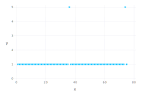

In [68]:
#calculando momentos para cada S

#manipulando DataFrame

using Gadfly
plot(x=collect(1:1:N), y=Results[1, :, 5])


In [122]:
#criei assim porque é um saco renomear colunas em Julia

DF = DataFrame()
DF.payoff_s = Results[1,:,1];
DF.payoff_j = Results[1,:,2];
DF.out = Results[1,:,3];
DF.t = Results[1,:,4];
DF.observed_proposals = Results[1,:,5];
DF

,payoff_s,payoff_j,out,t,observed_proposals
,Float64,Float64,Float64,Float64,Float64
1,0.25,0.37,3.0,1.0,1.0
2,0.25,0.37,3.0,1.0,1.0
3,0.25,0.42,3.0,1.0,1.0
4,0.25,0.36,3.0,1.0,1.0
5,0.25,0.36,3.0,1.0,1.0
6,0.25,0.36,3.0,1.0,1.0
7,0.25,0.36,3.0,1.0,1.0
8,0.25,0.36,3.0,1.0,1.0
9,0.25,0.37,3.0,1.0,1.0


In [89]:
#como criar variável dummy
# Y = ifelse.(DF.x3 .== 3.0, "Reorganized", "Liquidated");

In [130]:
DF.outcome = ifelse.(DF.out .==3.0, "R", "L");


#desfazendo o deslocamento no índice de t
DF.t = DF.t .- 1.0;

75-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 4.0
 0.0

In [134]:
DF.incourt = ifelse.(DF.t .> 0.0, "incourt", "precourt");

In [138]:
A = filter(DF -> DF.incourt.=="incourt", DF)

,payoff_s,payoff_j,out,t,observed_proposals,outcome,incourt
,Float64,Float64,Float64,Float64,Float64,String,String
1,0.274745,0.135492,3.0,4.0,5.0,R,incourt
2,0.190167,0.177921,3.0,4.0,5.0,R,incourt


In [140]:
A

,payoff_s,payoff_j,out,t,observed_proposals,outcome,incourt
,Float64,Float64,Float64,Float64,Float64,String,String
1,0.274745,0.135492,3.0,4.0,5.0,R,incourt
2,0.190167,0.177921,3.0,4.0,5.0,R,incourt


In [139]:
mean(A.payoff_s)

0.23245574958999016

Calculando momentos

In [177]:
#1. avg log number of months between observed proposals incourt

mm1 = filter(DF -> DF.incourt.=="incourt", DF);
mm1 = log.(mm1.t .* μ ./ mm1.observed_proposals)
mm1 = mean(mm1)

1.295493996793394

In [148]:
#2. fraction reorganized given that the case went into court

mm2 = filter(DF -> DF.incourt.=="incourt", DF);
mm2 = size(filter(mm2 -> mm2.outcome .== "R", mm2),1)/ size(mm2,1)

1.0

In [180]:
#3. ln duration of court cases in months

mm3 = filter(DF -> DF.incourt .=="incourt", DF)
mm3 = filter(mm3 -> mm3.t .> 0.0, mm3) #removendo os casos 0 para não poluir a média
mm3.t = mm3.t .* μ
mm3 = mean(log.(mm3.t)) #log here uses exp as base, so it's the same as ln

2.9049319092274946

In [162]:
#4. fraction of cases incourt
mm4 = size(filter(DF -> DF.incourt .== "incourt", DF),1) / size(DF, 1)

0.02666666666666667

In [170]:
#5. avg recovery rate for senior given precourt

#aqui nós temos Ds, então é mais fácil. Preciso automatizar isso no código quando for tudo escalado

mm5 = filter(DF -> DF.incourt .== "precourt", DF)
mm5.payoff_s = mm5.payoff_s ./ Ds
mm5 = mean(mm5.payoff_s)


0.7659238862149821

In [171]:
#6. avg recovery rate for junior given precourt

#aqui nós temos Ds, então é mais fácil. Preciso automatizar isso no código quando for tudo escalado

mm6 = filter(DF -> DF.incourt .== "precourt", DF)
mm6.payoff_j = mm6.payoff_j ./ Dj
mm6 = mean(mm6.payoff_j)


0.5695553349533067

In [172]:
#7. junior avg fraction gain given incourt

mm7 = filter(DF -> DF.incourt .== "incourt", DF)
mm7 = mean(mm7.payoff_j ./ (mm7.payoff_j .+ mm7.payoff_s )) 

0.40682138654277455

In [173]:
#8. total recovery rate given incourt

mm8 = filter(DF -> DF.incourt .== "incourt", DF)
mm8 = mean( mm8.payoff_s .+ mm8.payoff_j)

0.38916210073777624